# Forecasting metrics: case 5

In this notebooks forecast metrics for all models fitted for the simulation case 5 are calculated and saved to a single file.

In [2]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [3]:
case = "case_5"
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", case)

In [4]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,6.0,3.0,6.0,95.0,7.0,34.0,63.0,354.0,5.0,152.0
1,6.0,3.0,5.0,83.0,3.0,32.0,63.0,352.0,5.0,150.0
2,5.0,3.0,8.0,83.0,4.0,33.0,71.0,343.0,10.0,152.0
3,8.0,3.0,10.0,98.0,9.0,37.0,66.0,339.0,4.0,167.0
4,6.0,5.0,7.0,85.0,12.0,28.0,61.0,324.0,2.0,169.0


In [5]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 10)
(12, 10)


In [6]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [7]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [8]:
sarima_prediction = sarima_model.predict(12)

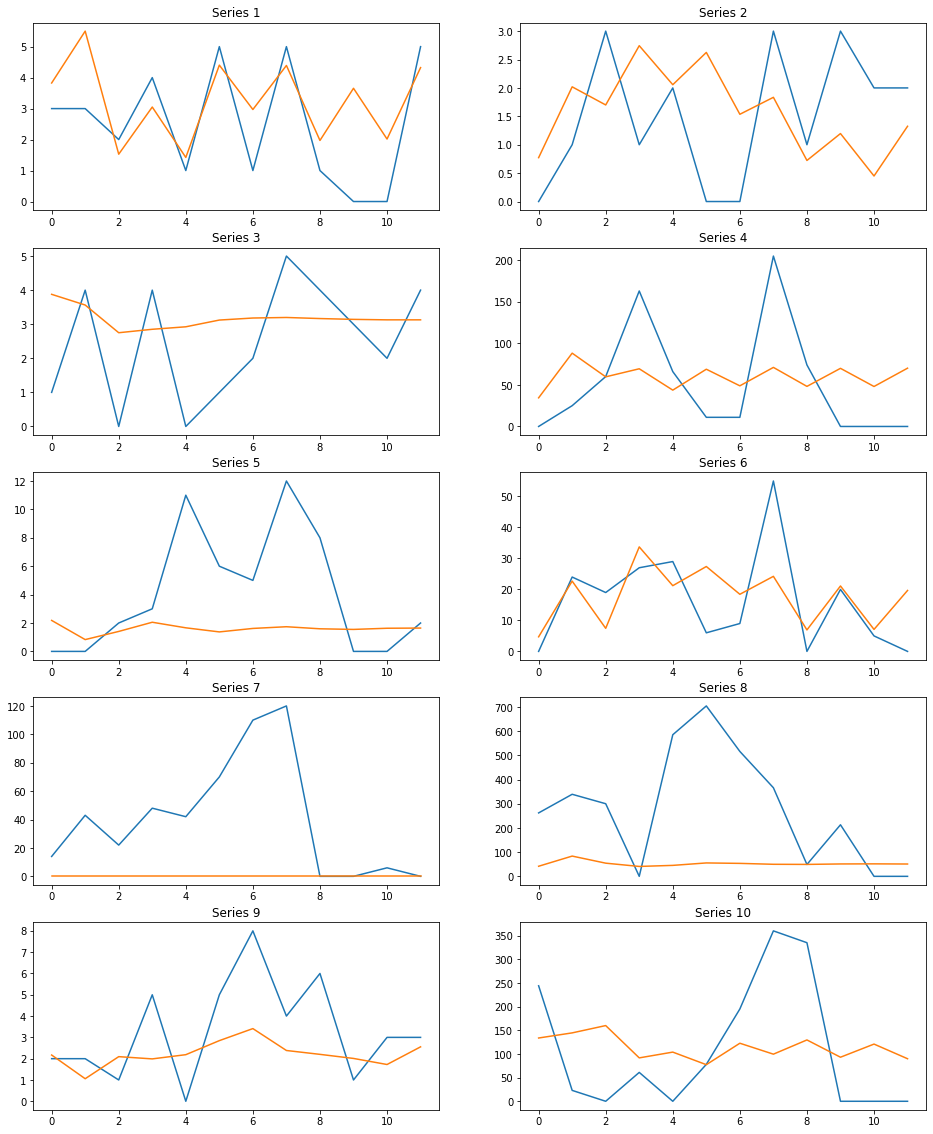

In [9]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=2)

In [10]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case=case
)
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [11]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [35]:
poisson_ar_prediction = poisson_ar_model.predict(12)

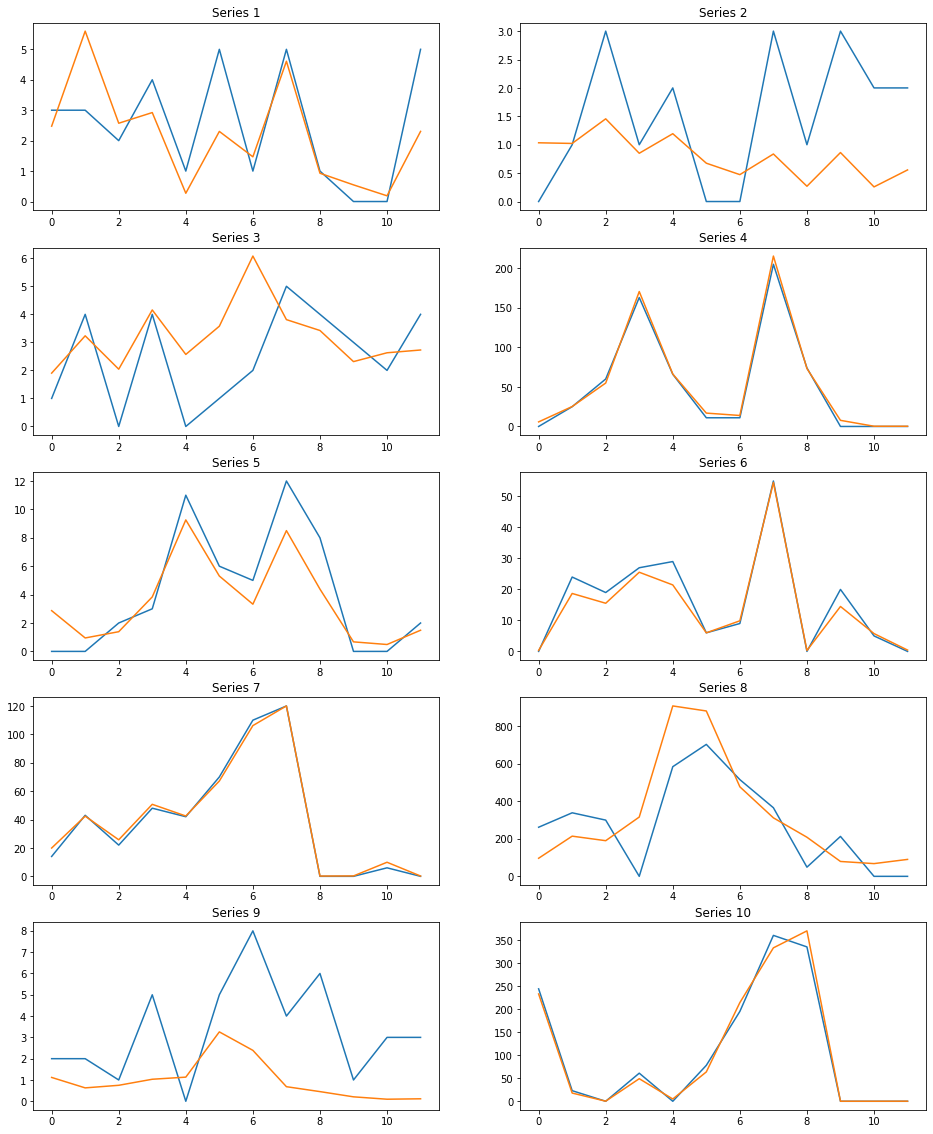

In [36]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=2)

In [14]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 12 timesteps input

In [15]:
input_steps=12

In [16]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [17]:
scaled_data = rnn_scaler.transform(train_data[-input_steps:]).reshape((1,input_steps,-1))

In [18]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [19]:
rnn_prediction = rnn_model.predict(scaled_data)

1/1 [==============================] - 3s 3s/step


In [20]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction[0])

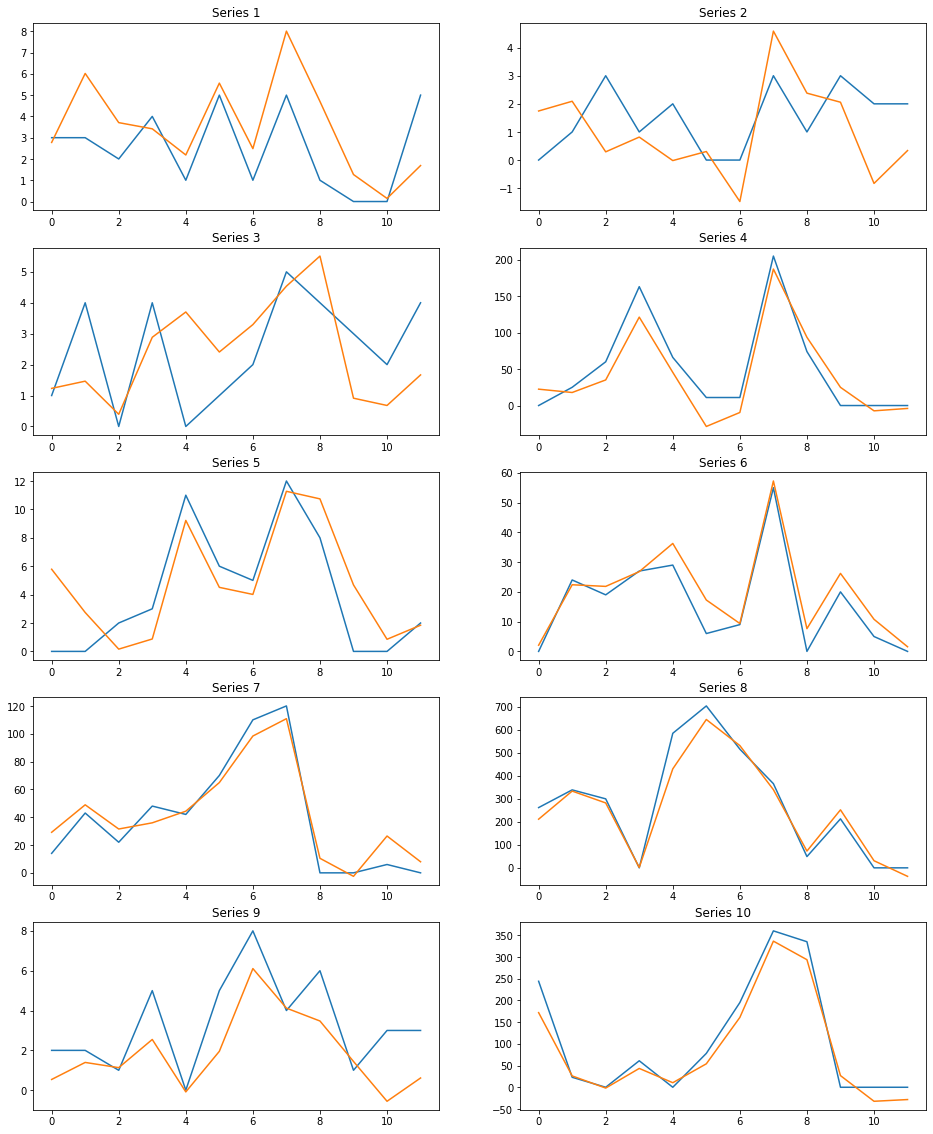

In [21]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=2)

In [22]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case=case
)
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [23]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [24]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [25]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [26]:
inputs = train_data[-12:]

In [27]:
transformer_prediction = forecaster(inputs=inputs, steps=12)

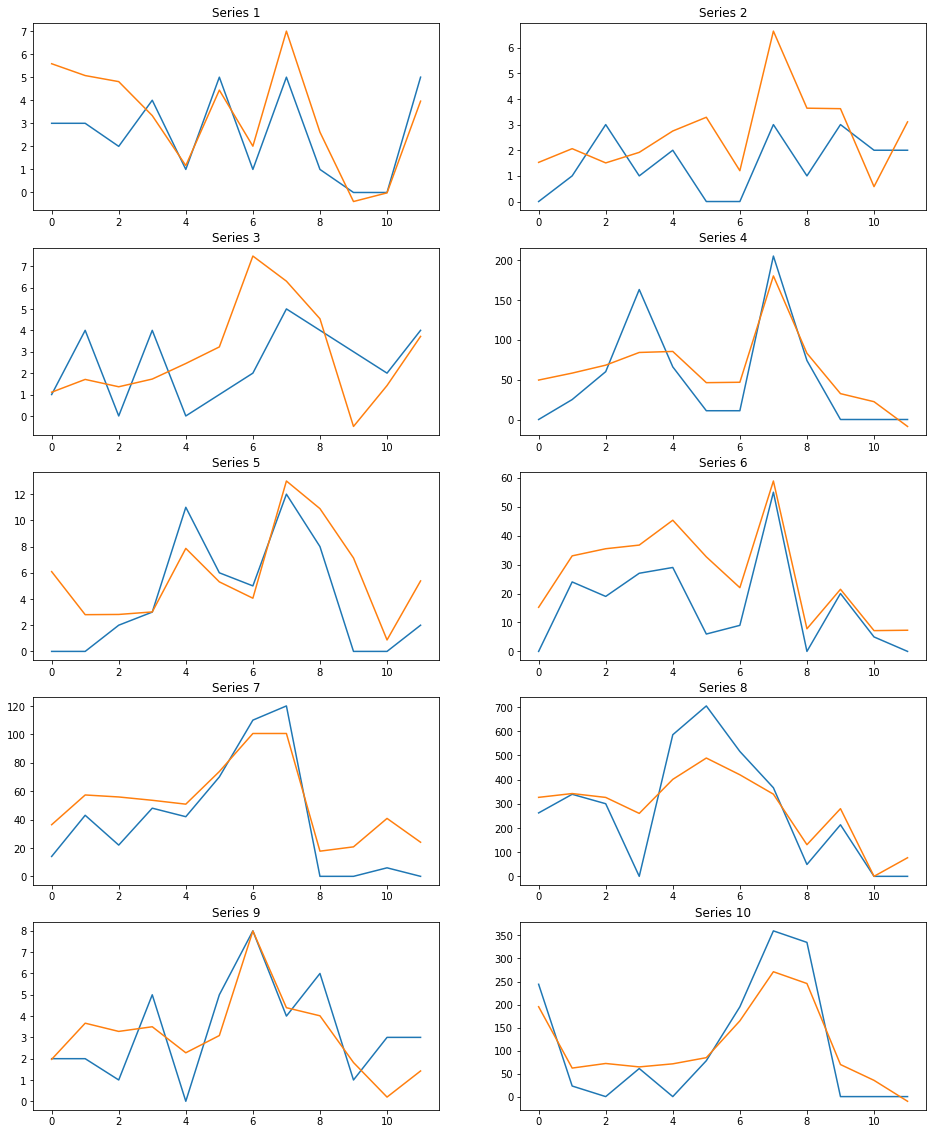

In [28]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=2)

In [29]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case=case
)
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [30]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression            \
                  sMAPE      MASE                   sMAPE      MASE   
case_5 mean  106.282704  1.344964               84.115362  0.556415   
       sd     30.753731  0.715885               20.212237  0.455604   
       min    64.705477  0.504458               59.657671  0.116357   
       max   150.000000  2.559343              123.972726  1.506817   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_5 mean                89.576062  0.608069   85.888917  0.845145  
       sd                  19.850761  0.155221   12.439385  0.149018  
       min                 61.226228  0.343246   66.953505  0.480511  
       max                129.836153  0.851656  104.441978  1.061897

In [31]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)